In [75]:
import polars as pl
import numpy as np
import os
import networkx as nx
from statsmodels.tsa.stattools import grangercausalitytests
import tqdm
import matplotlib.pyplot as plt

In [76]:
lengths = set()

dfs = dict()

for path in os.listdir('./ticker_data'):
    if 'all_stocks' in path or '.csv' not in path: continue
    df = pl.read_csv(os.path.join('./ticker_data', path))
    dfs[path.split('.')[0]] = df


In [79]:
lags = [1, 2, 4]
lag_graph = [nx.DiGraph() for lag in lags]
for g in lag_graph: g.add_nodes_from(list(dfs.keys()))

for key1 in tqdm.tqdm(list(dfs.keys())):
    for key2 in dfs.keys():
        if key1 == key2: continue
        key1_dates = set(pl.Series(dfs[key1].select('begin')).to_list())
        key2_data = dfs[key2].filter(pl.col('begin').is_in(key1_dates))
        key2_dates = set(pl.Series(key2_data.select('begin')).to_list())
        key1_data = dfs[key1].filter(pl.col('begin').is_in(key2_dates))

        key1_prices = pl.Series(key1_data.select('close')).to_list()
        key2_prices = pl.Series(key2_data.select('close')).to_list()
        comp_data = np.stack([key1_prices, key2_prices], -1)
        tests_data = grangercausalitytests(comp_data, lags, verbose=False)
        
        for idx, lag in enumerate(lags):
            pval = tests_data[lag][0]['ssr_ftest'][1]
            if pval <= 0.05:
                lag_graph[idx].add_edge(key2, key1, weight=pval)

  0%|          | 0/213 [00:00<?, ?it/s]c:\Users\admin\work\News-Sentiment-aware-Stock-Prediction\.conda\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████| 213/213 [08:39<00:00,  2.44s/it]


In [80]:
for lag, g in zip(lags, lag_graph):
    nx.write_graphml(g, f'causal_graphs/lag{lag}_causality_graph.graphml')

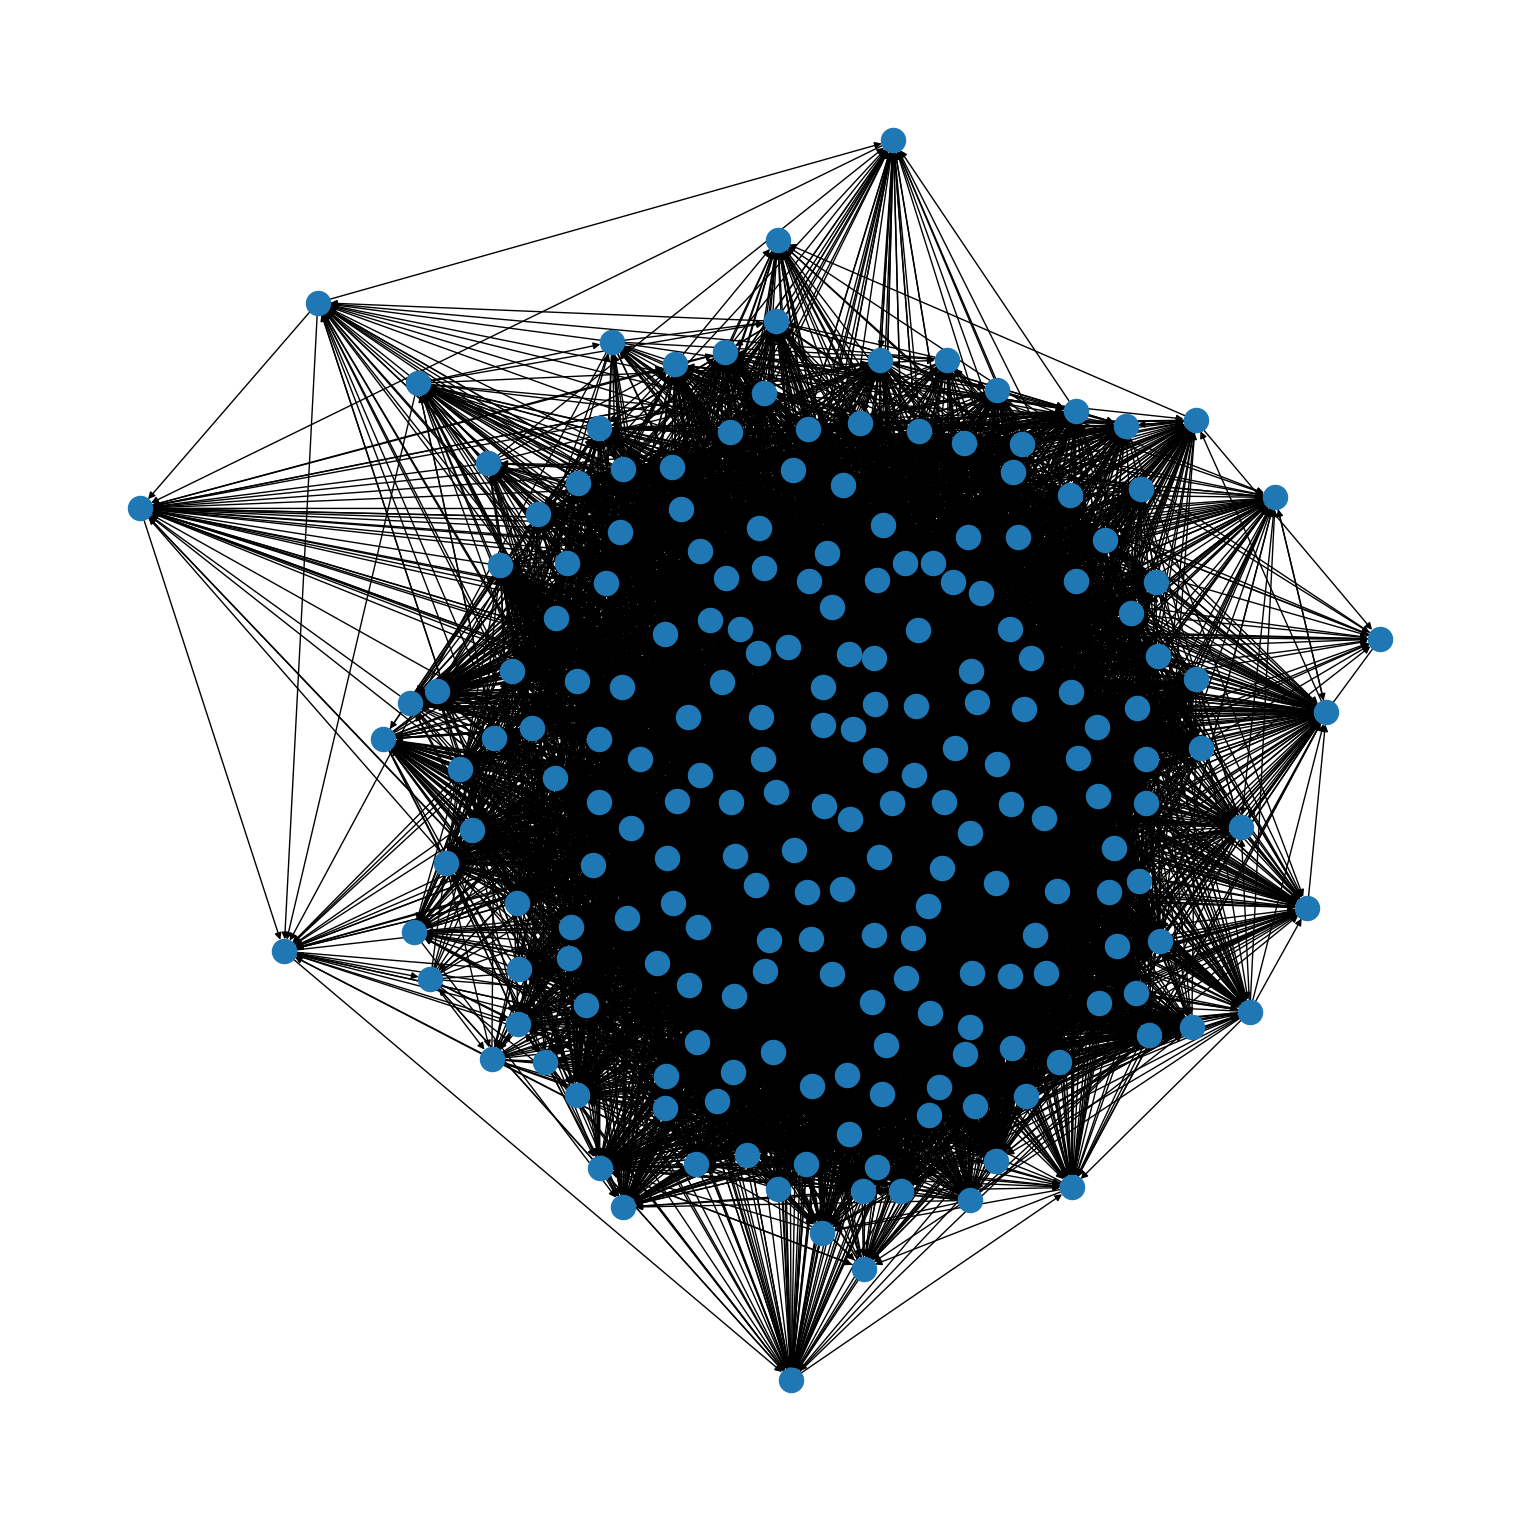

In [ ]:
nx.draw(lag_graph[0])
plt.gcf().set_size_inches(15, 15)

In [92]:
in_degree_centrality = nx.in_degree_centrality(lag_graph[0])
sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)

[('ROST', 0.6415094339622641),
 ('YRSBP', 0.5990566037735848),
 ('ETLN', 0.5424528301886792),
 ('YRSB', 0.5330188679245282),
 ('GAZA', 0.5188679245283019),
 ('KROTP', 0.5094339622641509),
 ('ARSA', 0.49528301886792453),
 ('KCHE', 0.49528301886792453),
 ('KCHEP', 0.4858490566037736),
 ('TORS', 0.46226415094339623),
 ('UTAR', 0.4528301886792453),
 ('JNOS', 0.44811320754716977),
 ('SAGOP', 0.44811320754716977),
 ('VJGZP', 0.44811320754716977),
 ('KAZT', 0.4433962264150943),
 ('KROT', 0.4433962264150943),
 ('KAZTP', 0.4386792452830188),
 ('KZOSP', 0.4386792452830188),
 ('TUZA', 0.43396226415094336),
 ('OMZZP', 0.4292452830188679),
 ('TNSE', 0.4292452830188679),
 ('NNSBP', 0.4245283018867924),
 ('TORSP', 0.4245283018867924),
 ('WTCM', 0.4245283018867924),
 ('KGKC', 0.41981132075471694),
 ('UKUZ', 0.410377358490566),
 ('VJGZ', 0.410377358490566),
 ('MISB', 0.40094339622641506),
 ('MGNZ', 0.38679245283018865),
 ('FLOT', 0.3773584905660377),
 ('KMEZ', 0.3773584905660377),
 ('MRKP', 0.377358490